In [1]:
#!/usr/bin/env python3

"""
Bond yield utilities:
- current_yield
- yield_to_maturity (YTM)
- yield_to_call (YTC)
- yield_to_worst (YTW)
"""

def current_yield(annual_coupon: float, price: float) -> float:
    """
    Current Yield = Annual Coupon / Current Price
    Returns a decimal (e.g., 0.055 = 5.5%)
    """
    return annual_coupon / price


def _present_value_of_bond(price: float,
                           face_value: float,
                           coupon_rate: float,
                           years_to_maturity: float,
                           frequency: int,
                           yield_per_period: float,
                           final_value: float = None) -> float:
    """
    Internal helper to compute price difference given a trial yield.
    final_value: what you receive in the final period (face_value by default,
                 or call_price for YTC).
    Returns: model_price - market_price
    """
    if final_value is None:
        final_value = face_value

    periods = int(round(years_to_maturity * frequency))
    coupon_per_period = face_value * coupon_rate / frequency

    model_price = 0.0
    for t in range(1, periods + 1):
        cf = coupon_per_period
        if t == periods:
            cf += final_value
        model_price += cf / ((1 + yield_per_period) ** t)

    return model_price - price


def _solve_yield(price: float,
                 face_value: float,
                 coupon_rate: float,
                 years_to_maturity: float,
                 frequency: int = 1,
                 final_value: float = None,
                 tol: float = 1e-8,
                 max_iter: int = 10_000) -> float:
    """
    Generic solver for yield per period using bisection.
    Returns yield_per_period (e.g., 0.03 = 3% per period).
    """
    # Lower and upper bounds for yield per period
    low = -0.9999    # can't have rate <= -100%
    high = 1.0       # 100% per period (very generous upper bound)

    f_low = _present_value_of_bond(
        price, face_value, coupon_rate, years_to_maturity, frequency, low, final_value
    )
    f_high = _present_value_of_bond(
        price, face_value, coupon_rate, years_to_maturity, frequency, high, final_value
    )

    # Ensure the root is bracketed
    if f_low * f_high > 0:
        raise ValueError("Unable to bracket the yield; try different bounds or check inputs.")

    for _ in range(max_iter):
        mid = (low + high) / 2.0
        f_mid = _present_value_of_bond(
            price, face_value, coupon_rate, years_to_maturity, frequency, mid, final_value
        )

        if abs(f_mid) < tol:
            return mid

        # Bisection step
        if f_low * f_mid < 0:
            high = mid
            f_high = f_mid
        else:
            low = mid
            f_low = f_mid

    # If we get here, we didn't converge
    raise RuntimeError("Yield solver did not converge.")


def yield_to_maturity(price: float,
                      face_value: float,
                      coupon_rate: float,
                      years_to_maturity: float,
                      frequency: int = 1) -> float:
    """
    Compute Yield to Maturity (YTM).

    price            : current market price of the bond
    face_value       : par value (e.g., 1000)
    coupon_rate      : annual coupon rate as decimal (e.g., 0.05 = 5%)
    years_to_maturity: years to final maturity
    frequency        : coupon payments per year (1=annual, 2=semiannual, etc.)

    Returns:
        nominal annual YTM (decimal), i.e. yield_per_period * frequency.
        Example: 0.06 = 6% per year.
    """
    y_per_period = _solve_yield(
        price=price,
        face_value=face_value,
        coupon_rate=coupon_rate,
        years_to_maturity=years_to_maturity,
        frequency=frequency,
        final_value=face_value,
    )
    return y_per_period * frequency


def yield_to_call(price: float,
                  face_value: float,
                  coupon_rate: float,
                  years_to_call: float,
                  call_price: float,
                  frequency: int = 1) -> float:
    """
    Compute Yield to Call (YTC).

    price       : current market price of the bond
    face_value  : par value
    coupon_rate : annual coupon rate as decimal
    years_to_call: years until first call date
    call_price  : price paid at call date
    frequency   : coupon payments per year

    Returns:
        nominal annual YTC (decimal), i.e. yield_per_period * frequency.
    """
    y_per_period = _solve_yield(
        price=price,
        face_value=face_value,
        coupon_rate=coupon_rate,
        years_to_maturity=years_to_call,
        frequency=frequency,
        final_value=call_price,
    )
    return y_per_period * frequency


def yield_to_worst(price: float,
                   face_value: float,
                   coupon_rate: float,
                   years_to_maturity: float,
                   call_schedule=None,
                   frequency: int = 1) -> float:
    """
    Compute Yield to Worst (YTW).

    call_schedule: list of dicts like:
        [
            {"years_to_call": 5, "call_price": 1020},
            {"years_to_call": 10, "call_price": 1010},
            ...
        ]
      If None or empty, this just returns YTM.

    Returns:
        The lowest yield among YTM and all YTCs (decimal).
    """
    if call_schedule is None:
        call_schedule = []

    # Start with YTM
    ytm = yield_to_maturity(price, face_value, coupon_rate,
                            years_to_maturity, frequency)
    yields = [ytm]

    # Add all YTCs from the call schedule
    for call in call_schedule:
        ytc = yield_to_call(
            price=price,
            face_value=face_value,
            coupon_rate=coupon_rate,
            years_to_call=call["years_to_call"],
            call_price=call["call_price"],
            frequency=frequency,
        )
        yields.append(ytc)

    return min(yields)


# ---------------------------------------------------------------------
# Example usage
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # Example bond
    face = 1000.0
    coupon_rate = 0.05      # 5% coupon
    price = 920.0           # trades below par
    years_to_maturity = 10
    frequency = 2           # semiannual coupons

    annual_coupon = face * coupon_rate
    cy = current_yield(annual_coupon, price)
    ytm = yield_to_maturity(price, face, coupon_rate, years_to_maturity, frequency)

    print(f"Current Yield: {cy * 100:.3f}%")
    print(f"Yield to Maturity (nominal annual): {ytm * 100:.3f}%")

    # Callable example
    call_schedule = [
        {"years_to_call": 5, "call_price": 1020.0},
        {"years_to_call": 7, "call_price": 1010.0},
    ]

    ytc_first = yield_to_call(price, face, coupon_rate,
                              years_to_call=5, call_price=1020.0,
                              frequency=frequency)
    ytw = yield_to_worst(price, face, coupon_rate,
                         years_to_maturity, call_schedule,
                         frequency)

    print(f"Yield to First Call: {ytc_first * 100:.3f}%")
    print(f"Yield to Worst: {ytw * 100:.3f}%")


Current Yield: 5.435%
Yield to Maturity (nominal annual): 6.079%
Yield to First Call: 7.276%
Yield to Worst: 6.079%


Benchmark Yield Measures Markets for Comparison (second slide)

In [10]:
"""
Benchmark Yield Background for Comparison Purposes
--------------------------------------------------

🇩🇪 German Bund Market:
- “Bunds” = German government bonds.
- They are the primary benchmark for long-term European bond yields.
- Investors commonly compare: French vs Bunds, Italian vs Bunds, Corporate vs Bunds.
- Bunds are viewed as the European risk-free long-term benchmark (similar to U.S. Treasuries).

🏦 LIBOR (London Interbank Offered Rate):
- Historically the short-term worldwide benchmark interest rate.
- Used as a reference for pricing loans, derivatives, and short-term funding.
- LIBOR represented the rate at which major global banks lent to each other.

➡ Comparison Summary:
- Bund yield = **long-term** benchmark rate (10-year horizon reference).
- LIBOR = **short-term** benchmark rate (overnight–12 months).

Below is a script to fetch current long-term benchmark yields using
Yahoo Finance via the yfinance module.
"""

import yfinance as yf

# Yahoo Finance benchmark yield tickers
tickers = {
    "Germany 10Y Bund": "^DE10Y",
    "UK 10Y Gilt": "^GB10Y",
    "Japan 10Y JGB": "^JP10Y",
    "US 10Y Treasury": "^TNX"   # Note: TNX = yield * 10
}

def get_yield(ticker):
    """Fetch the most recent yield value for a given Yahoo Finance ticker."""
    data = yf.Ticker(ticker).history(period="1d")
    if data.empty:
        return None
    price = data["Close"].iloc[-1]

    # TNX returns yield * 10 → convert back to %
    if ticker == "^TNX":
        price = price / 10

    return price

# Fetch and display benchmark yields
for name, ticker in tickers.items():
    y = get_yield(ticker)
    if y is not None:
        print(f"\n{name}: {y:.3f}%")
    else:
        print(f"\n{name}: No data available")

import pandas as pd
import requests

# EXAMPLE ONLY – may need tweaking if sites change layout


$^DE10Y: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")



Germany 10Y Bund: No data available


$^GB10Y: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")



UK 10Y Gilt: No data available


$^JP10Y: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")



Japan 10Y JGB: No data available

US 10Y Treasury: 0.406%


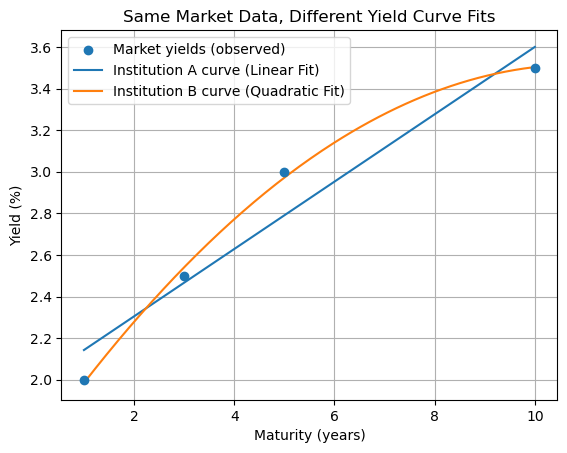

In [12]:
"""
Yield Curve Construction Demo:
------------------------------

Goal:
    Show how different financial institutions can build slightly 
    different yield curves even when they observe the SAME market data.

Key Concepts:
    • There is NOT one single universal "yield curve."
      Instead, institutions take the same market bond yields and 
      FIT a smooth curve using their own models.

    • Market Data (same for everyone):
        - A set of observed yields at specific maturities.
        - Example: 1Y, 3Y, 5Y, 10Y government bond yields.

    • Curve Fitting:
        Institution A → uses a simple LINEAR model  
        Institution B → uses a QUADRATIC (curved) model  
        This produces different yield curves *between* the data points.

    • Why this matters:
        - Discount factors, forward rates, and risk measures 
          depend on the shape of the yield curve.
        - Even small modelling differences can lead to 
          different valuations and risk numbers.

This script:
    1. Defines the same market yields for both institutions.
    2. Fits a linear curve (Inst A).
    3. Fits a quadratic curve (Inst B).
    4. Plots both curves alongside the original market points.
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit as polyfit_linear
from numpy.polynomial.polynomial import polyval as polyval_linear
from numpy.polynomial import Polynomial

# ------------------------------------------------------------
# 1. MARKET DATA (same for all institutions)
# ------------------------------------------------------------
# Toy example of observed zero-coupon yields (in %)
maturities = np.array([1, 3, 5, 10])     # maturities in years
yields = np.array([2.0, 2.5, 3.0, 3.5])  # observed market yields (%)

# ------------------------------------------------------------
# 2. INSTITUTION A: LINEAR YIELD CURVE FIT
# ------------------------------------------------------------
# Fit a degree-1 polynomial (straight line)
coef_A = polyfit_linear(maturities, yields, 1)
# Create a callable function for curve A
curve_A = lambda t: polyval_linear(t, coef_A)

# ------------------------------------------------------------
# 3. INSTITUTION B: QUADRATIC YIELD CURVE FIT
# ------------------------------------------------------------
# Fit a degree-2 polynomial (curved parabola)
poly_B = Polynomial.fit(maturities, yields, 2).convert()
coef_B = poly_B.coef
# Create callable function for curve B (using np.polyval format)
curve_B = lambda t: np.polyval(coef_B[::-1], t)

# ------------------------------------------------------------
# 4. PLOT BOTH CURVES + MARKET DATA
# ------------------------------------------------------------
grid = np.linspace(1, 10, 200)  # smooth x-axis for plotting curves

plt.figure()
plt.scatter(maturities, yields, label="Market yields (observed)", zorder=3)
plt.plot(grid, curve_A(grid), label="Institution A curve (Linear Fit)")
plt.plot(grid, curve_B(grid), label="Institution B curve (Quadratic Fit)")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Same Market Data, Different Yield Curve Fits")
plt.legend()
plt.grid(True)
plt.show()


Fetching high-yield spread series 'BAMLH0A0HYM2' from FRED...
Latest ICE BofA US High Yield OAS:
  Date   : 2025-12-19
  Spread : 2.90 percentage points over Treasuries


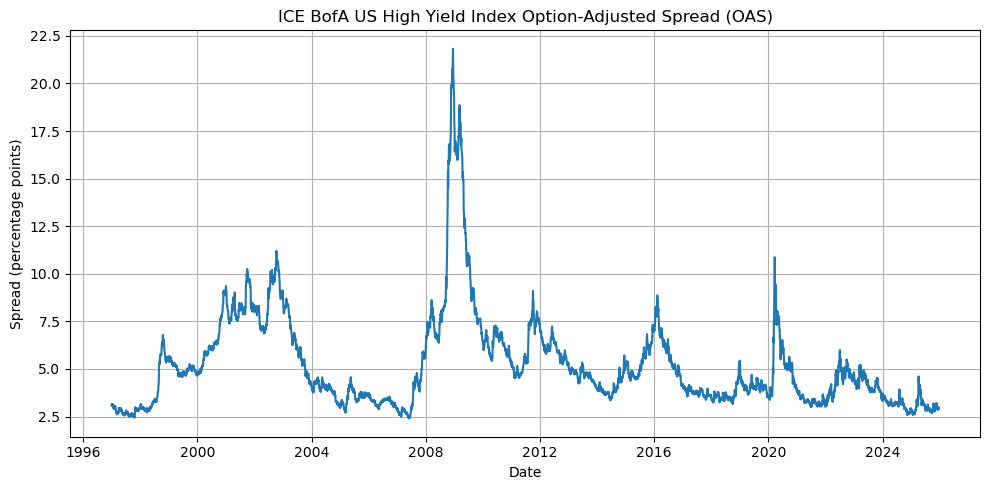

In [1]:
"""
High-Yield Credit Spread Monitor
--------------------------------

What this script does:
    - Downloads the ICE BofA US High Yield Index Option-Adjusted Spread (OAS)
      from the Federal Reserve's FRED database.
    - Plots the time series (how high-yield spreads move over time).
    - Prints the latest spread value.

Concepts:
    - High-yield (junk) bonds have higher credit risk, so they trade at a
      *spread* over risk-free government bond yields.
    - The ICE BofA US High Yield OAS is a standard benchmark measure of
      how wide those spreads are on average for US high-yield corporates.
    - Wider OAS = market demands more compensation for credit risk
      (risk-off, stress in credit markets).
"""

import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# ------------------------------------------------------------
# 1. CONFIGURATION
# ------------------------------------------------------------

# Put your FRED API key here (get one free from https://fred.stlouisfed.org/)
FRED_API_KEY = "4ef9f0d5580d1cc1581a1f81b2e6094f"

# FRED series ID for ICE BofA US High Yield Index Option-Adjusted Spread
SERIES_ID = "BAMLH0A0HYM2"

# ------------------------------------------------------------
# 2. DOWNLOAD DATA FROM FRED
# ------------------------------------------------------------

def fetch_fred_series(series_id: str, api_key: str) -> pd.DataFrame:
    """
    Fetch a time series from FRED and return as a pandas DataFrame.
    """
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        # optional: start_date, end_date
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    # Convert JSON observations to DataFrame
    obs = data["observations"]
    df = pd.DataFrame(obs)
    df["date"] = pd.to_datetime(df["date"])
    # 'value' is a string in the JSON; convert to float, handle '.' for missing
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    # Keep only date + value, rename 'value' -> 'spread'
    df = df[["date", "value"]].rename(columns={"value": "spread"})
    df.set_index("date", inplace=True)
    return df

# ------------------------------------------------------------
# 3. MAIN SCRIPT
# ------------------------------------------------------------

def main():
    if FRED_API_KEY == "YOUR_FRED_API_KEY_HERE":
        raise ValueError("Please set FRED_API_KEY to your actual FRED API key.")

    print(f"Fetching high-yield spread series '{SERIES_ID}' from FRED...")
    df = fetch_fred_series(SERIES_ID, FRED_API_KEY)

    # Drop any missing values
    df = df.dropna()

    # Print the latest spread value
    latest_date = df.index[-1]
    latest_spread = df["spread"].iloc[-1]
    print(f"Latest ICE BofA US High Yield OAS:")
    print(f"  Date   : {latest_date.date()}")
    print(f"  Spread : {latest_spread:.2f} percentage points over Treasuries")

    # --------------------------------------------------------
    # 4. PLOT THE TIME SERIES
    # --------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df["spread"])
    plt.title("ICE BofA US High Yield Index Option-Adjusted Spread (OAS)")
    plt.xlabel("Date")
    plt.ylabel("Spread (percentage points)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


In [18]:
"""
Lightweight Rightmove Scraper for UK Property Liquidity
-------------------------------------------------------

What this does:
    • Takes a Rightmove "for sale" search URL (postcode/area search).
    • Fetches listing cards for 1+ pages.
    • Extracts:
        - Price
        - Address
        - Title/description
        - Listing URL
        - "Added on" text
        - Approximate Days on Market (DOM)

Concepts:
    • In real estate, shorter DOM = more liquid market.
    • Aggregating DOM per postcode/area can give a proxy for liquidity.

HOW TO USE:
    1. Go to https://www.rightmove.co.uk/
    2. Search for properties for sale in your target postcode/area.
    3. Copy the full URL from your browser (results page).
    4. Paste that URL into BASE_URL below.

Notes:
    • Rightmove pagination uses the `index` query parameter:
          index=0  -> first page
          index=24 -> second page
          index=48 -> third page
      We increment that to get multiple pages.
"""

import requests
from bs4 import BeautifulSoup
import time
import re
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse

# -------------------------------------------------
# 1. CONFIGURATION
# -------------------------------------------------

# Paste a Rightmove "for sale" search URL here, e.g.
# "https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=POSTCODE%5ESW1A&radius=0.25&index=0&sortType=6"
BASE_URL = "PASTE_YOUR_RIGHTMOVE_SEARCH_URL_HERE"

# How many pages to fetch (1 page = up to 24 results typically)
MAX_PAGES = 1   # Increase carefully, e.g. 2, 3...


# -------------------------------------------------
# 2. HELPER: UPDATE INDEX PARAM FOR PAGINATION
# -------------------------------------------------

def build_page_url(base_url: str, page: int, page_size: int = 24) -> str:
    """
    Given the original Rightmove URL (page 1, index=0),
    return the URL for the given page by adjusting the 'index' parameter.

    Rightmove convention:
        page 1 -> index = 0
        page 2 -> index = 24
        page 3 -> index = 48
        etc.
    """
    parsed = urlparse(base_url)
    qs = parse_qs(parsed.query)

    # index = (page - 1) * page_size
    qs["index"] = [str((page - 1) * page_size)]

    new_query = urlencode(qs, doseq=True)
    new_parsed = parsed._replace(query=new_query)
    return urlunparse(new_parsed)


# -------------------------------------------------
# 3. HELPER: PARSE "ADDED ON" TEXT INTO APPROX DOM
# -------------------------------------------------

def approximate_dom(added_text: str | None) -> int | None:
    """
    Convert strings like:
        'Added on 01/12/2025'
        'Added yesterday'
        'Added today'
        'Added on 15/11/2025'
    into an approximate number of days on market.

    NOTE:
        For simplicity, this function only handles some common patterns.
        You can extend it with datetime parsing if needed.
    """
    if not added_text:
        return None

    text = added_text.lower()

    if "today" in text:
        return 0
    if "yesterday" in text:
        return 1

    # Optional: parse 'Added on dd/mm/yyyy'
    m = re.search(r"(\d{2})/(\d{2})/(\d{4})", text)
    if m:
        from datetime import datetime, date
        day, month, year = map(int, m.groups())
        added_date = date(year, month, day)
        today = date.today()
        return (today - added_date).days

    return None


# -------------------------------------------------
# 4. SCRAPE LISTINGS
# -------------------------------------------------

headers = {
    "User-Agent": "Mozilla/5.0 (compatible; EducationalRightmoveScraper/1.0)"
}

listings = []

for page in range(1, MAX_PAGES + 1):
    url = build_page_url(BASE_URL, page)
    print(f"Fetching page {page}: {url}")

    resp = requests.get(url, headers=headers)
    if resp.status_code != 200:
        print(f"Failed to fetch page {page} (status {resp.status_code})")
        break

    soup = BeautifulSoup(resp.text, "html.parser")

    # Rightmove listing cards usually have class 'propertyCard'
    cards = soup.find_all("div", class_=re.compile("propertyCard"))
    if not cards:
        print(f"No listing cards found on page {page} – HTML structure may have changed.")
        break

    for card in cards:
        try:
            # Price
            price_tag = card.find("div", class_=re.compile("propertyCard-priceValue"))
            price = price_tag.get_text(strip=True) if price_tag else None

            # Title / short description
            title_tag = card.find("h2", class_=re.compile("propertyCard-title"))
            title = title_tag.get_text(strip=True) if title_tag else None

            # Address
            address_tag = card.find("address", class_=re.compile("propertyCard-address"))
            address = address_tag.get_text(strip=True) if address_tag else None

            # Link
            link_tag = card.find("a", href=True, class_=re.compile("propertyCard-link"))
            link = "https://www.rightmove.co.uk" + link_tag["href"] if link_tag else None

            # "Added on" / age text (this selector may need tweaking)
            added_tag = card.find(string=re.compile("Added"))
            added_text = added_tag.strip() if added_tag else None

            dom = approximate_dom(added_text)

            listings.append({
                "price": price,
                "title": title,
                "address": address,
                "url": link,
                "added_text": added_text,
                "approx_DOM": dom,
            })
        except Exception as e:
            print("Error parsing a listing:", e)

    # Be polite!
    time.sleep(2)


# -------------------------------------------------
# 5. PRINT RESULTS
# -------------------------------------------------

print("\n=== Extracted Rightmove Listings ===")
for item in listings:
    print(item)


Fetching page 1: PASTE_YOUR_RIGHTMOVE_SEARCH_URL_HERE?index=0


MissingSchema: Invalid URL 'PASTE_YOUR_RIGHTMOVE_SEARCH_URL_HERE?index=0': No scheme supplied. Perhaps you meant https://PASTE_YOUR_RIGHTMOVE_SEARCH_URL_HERE?index=0?